## Xception

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [2]:
num_classes = 1000
input_shape = [299, 299, 3]

batch_size = 16
num_epochs = 10

In [3]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, Dense, Flatten
from tensorflow.keras import Input, Model

### Convolution Batch-normalization block

In [14]:
def conv_bn(filters, kernel_size, strides=1, padding='valid', groups=1, name=None):
    def layer_fn(x):
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  groups=groups,
                  use_bias = False,
                  name=name)(x)
        x = BatchNormalization()(x)
        return x
    return layer_fn

## Simplified Inception module

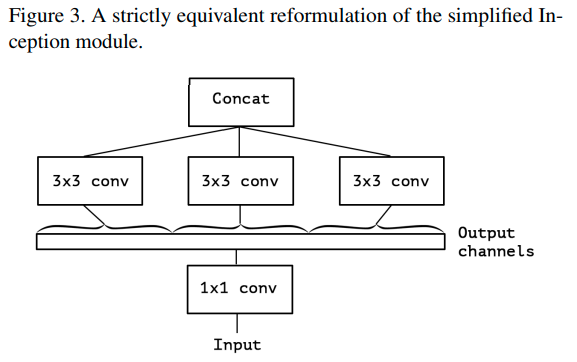

In [15]:
Image('image/xception_fig3.png')

In [39]:
def simplified_inception(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=3, name='3x3_conv')(x)
        return x
    return layer_fn

### Conv2D groups 테스트
* grouped_model 은 groups=3 설정으로 생성하고, ungrouped 은 groups=1 인 일반적인 Conv2D 로 생성했을 때 파라미터를 비교

In [40]:
def grouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = simplified_inception(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [41]:
def ungrouped_conv(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=1, name='3x3_conv')(x)
        return x
    return layer_fn

In [42]:
def ungrouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = ungrouped_conv(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [43]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16

In [44]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [45]:
model = grouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 96)        288       
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        27648     
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 flatten_8 (Flatten)         (None, 98304)             0   

In [46]:
model = ungrouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 96)        288       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        82944     
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 96)       384       
 chNormalization)                                                
                                                                 
 flatten_9 (Flatten)         (None, 98304)             0   

* ungrouped_model 의 3x3_conv 레이어의 파라미터 수는 82944
* grouped_model 의 3x3_conv 레이어의 파라미터 수는 27648

grouped_model 이 정확히 1/3 배의 파라미터수를 가지는 것으로 보아 3 개의 group 으로 정상적으로 작동함을 확인할 수 있었습니다. 

## Separable convolution block

In [22]:
def conv_separable(filters, kernel_size, strides, padding):
    def layer_fn(x):
        x = SeparableConv2D(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           padding=padding,
                           depth_multiplier=1)(x)
        x = BatchNormalization()(x)
        return x
    return layer_fn